In [1]:
pip install transformers torch numpy gudhi -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
text = ["במהלך שנת הלימודים הראשונה שלי באוניברסיטה, הצטרפתי לקבוצת טיול שהגיעה להר האייפל. למרות הקור החודר, הייתי מחויב לעלות לפסגה בכל בוקר, כדי לצפות בזרחת השמש מעל פריס"]

In [8]:
import torch
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel


def compute_output(sentence, layer, head):
    # Load pre-trained model
    tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis") #same as 'avichr/heBERT' tokenizer
    model = AutoModel.from_pretrained("avichr/heBERT_sentiment_analysis")


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

# Set the layer and head to use for computation
layer = 5
head = 10

# Compute the context vectors for each text in the corpus
context = [compute_output(t, layer, head) for t in text]
print(context[0].shape)
print(context[0])

Some weights of the model checkpoint at avichr/heBERT_sentiment_analysis were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 39, 64])
tensor([[[ 0.1052,  0.2825,  0.3925,  ..., -0.0220, -0.0928,  0.1957],
         [ 0.0340,  0.1643,  0.1072,  ...,  0.0735, -0.1738,  0.0407],
         [-0.0122,  0.1342,  0.0592,  ...,  0.0982, -0.1821, -0.0031],
         ...,
         [ 0.0847,  0.2292,  0.2436,  ...,  0.1563, -0.1178,  0.1256],
         [ 0.0094,  0.1848,  0.1876,  ...,  0.1110, -0.1408,  0.0592],
         [ 0.1072,  0.2812,  0.3880,  ..., -0.0203, -0.0954,  0.1970]]],
       grad_fn=<CloneBackward0>)


Barcode for text 0:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


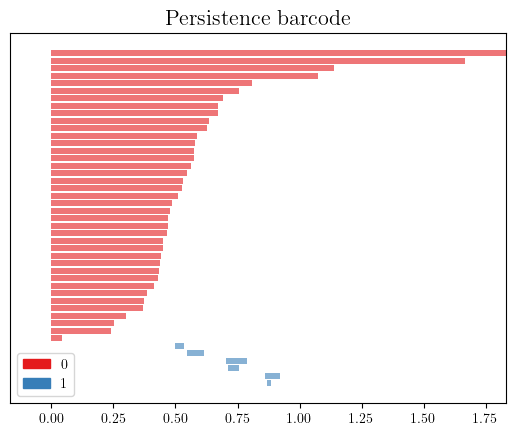

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix
import gudhi as gd

def compute_distances_and_plot_barcode(output):
    # Detach the output tensor, squeeze, and convert to numpy array
    output_np = output.squeeze().detach().numpy()

    # Compute the pairwise Euclidean distance matrix
    distances = distance_matrix(output_np, output_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)
    
    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

# Compute the barcode diagrams for each context vector
for i, output in enumerate(context):
    print(f"Barcode for text {i}:")
    compute_distances_and_plot_barcode(output)

In [16]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from transformers import BertTokenizer
from transformers import BertModel, BertTokenizerFast

def cluster_and_get_words(context, sentence, eps=0.51):
    # Load pre-trained model tokenizer
    tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis") #same as 'avichr/heBERT' tokenizer


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Squeeze the context tensor to remove the batch size dimension
    context = context.squeeze(0)

    # Compute the pairwise distance matrix
    distances = pdist(context.detach().numpy(), 'euclidean')
    dist_matrix = squareform(distances)

    # Run DBSCAN on the distance matrix
    clustering = DBSCAN(eps=eps, min_samples=2, metric='precomputed').fit(dist_matrix)

    # Get the words corresponding to each cluster
    clusters = {}
    for i, label in enumerate(clustering.labels_):
        if label != -1:  # Ignore noise (-1 label)
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(tokens[i])

    return clusters

# Compute the clusters for each context vector
clusters = []
for i, output in enumerate(context):
    print(f"Clusters for text {i}:")
    clusters.append(cluster_and_get_words(output, text[i]))
    for label, words in clusters[-1].items():
        print(f"Cluster {label}: {', '.join(words)}")

Clusters for text 0:
Cluster 0: [CLS], [SEP]
Cluster 1: במהלך, שנת, הלימודים, הראשונה, באוניברסיטה, ,, שהגיעה, האי, ##יפל, למרות, ##גה, ##ס
Cluster 2: הקור, ##ודר
Cluster 3: ,, מחויב
Cluster 4: בכל, בוקר, ,, כדי, בז
Cluster 5: ##רחת, השמש


Tokens of the sub-collection: ['לצפות', 'בז', '##רחת', 'השמש']
Distance matrix: (4, 4)
Distance matrix: [[0.         0.61433193 0.37320168 1.03062497]
 [0.61433193 0.         0.73159281 1.00894782]
 [0.37320168 0.73159281 0.         0.91390435]
 [1.03062497 1.00894782 0.91390435 0.        ]]


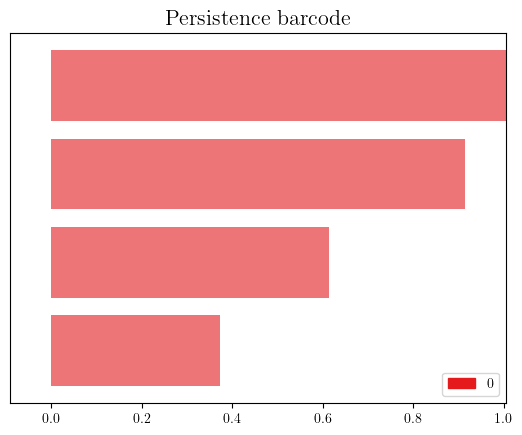

[(0, (0.0, inf)),
 (0, (0.0, 0.9139043491717304)),
 (0, (0.0, 0.6143319315022499)),
 (0, (0.0, 0.3732016768363685))]

In [25]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

def compute_phrase_distances_and_homology(context_vectors, sentence, phrase):
    # Initialize the tokenizer
    # tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis") #same as 'avichr/heBERT' tokenizer

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = [i for i, token in enumerate(sentence_tokens) if token in phrase_tokens]

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    print(f'Distance matrix: {distances.shape}')
    print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    gd.plot_persistence_barcode(persistence=persistent_homology)
    plt.show()

    return persistent_homology

# Assuming that 'context_vectors' is the tensor of context vectors for your sentence,
# and 'sentence' is your original sentence, you can use the function like this:
compute_phrase_distances_and_homology(context[0], text[0], "לצפות בזרחת השמש")

Some weights of the model checkpoint at avichr/heBERT_sentiment_analysis were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tokens of the sub-collection: ['לצפות', 'בז', '##רחת', 'השמש']
Distance matrix: (4, 4)
Distance matrix: [[0.         1.32658699 1.45146075 1.98166523]
 [1.32658699 0.         0.58626989 1.03090597]
 [1.45146075 0.58626989 0.         0.68099496]
 [1.98166523 1.03090597 0.68099496 0.        ]]


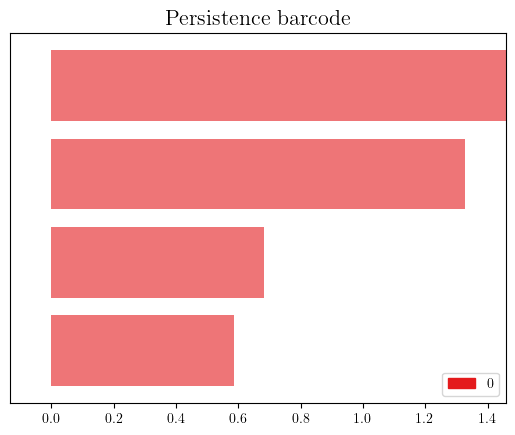

[(0, (0.0, inf)),
 (0, (0.0, 1.3265869892439848)),
 (0, (0.0, 0.6809949567904156)),
 (0, (0.0, 0.586269887421137))]

In [27]:
context_2 = [compute_output(t, layer, head) for t in text_2]
compute_phrase_distances_and_homology(context_2[0], text_2[0], "לצפות בזרחת השמש")

Tokens of the sub-collection: ['לצפות', 'בז', '##רחת', 'השמש']
Distance matrix: (4, 4)
Distance matrix: [[0.         0.61433193 0.37320168 1.03062497]
 [0.61433193 0.         0.73159281 1.00894782]
 [0.37320168 0.73159281 0.         0.91390435]
 [1.03062497 1.00894782 0.91390435 0.        ]]


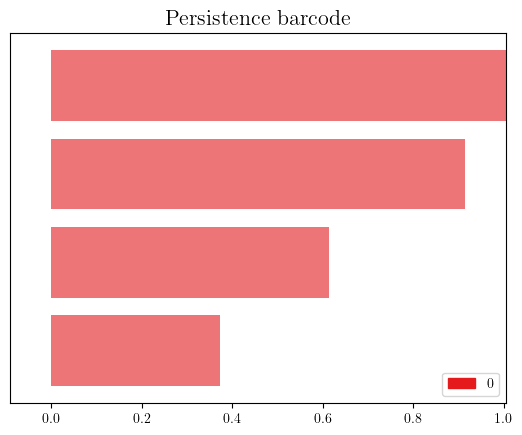

Tokens of the sub-collection: ['לצפות', 'בז', '##רחת', 'השמש']
Distance matrix: (4, 4)
Distance matrix: [[0.         1.32658699 1.45146075 1.98166523]
 [1.32658699 0.         0.58626989 1.03090597]
 [1.45146075 0.58626989 0.         0.68099496]
 [1.98166523 1.03090597 0.68099496 0.        ]]


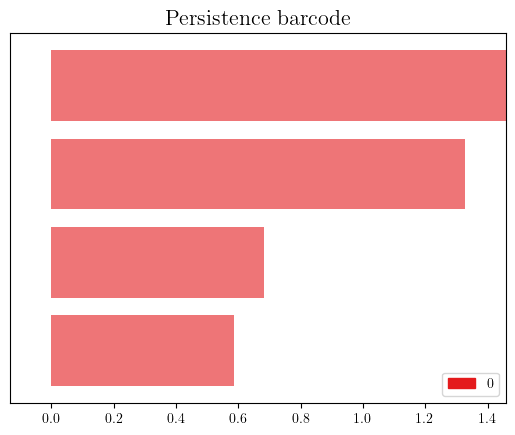

Bottleneck distance: 0.4126826400722544
Wasserstein distance: = 0.69


In [30]:
# Compute the persistent homology
persistent_homology_1 = compute_phrase_distances_and_homology(context[0], text[0], "לצפות בזרחת השמש")
persistent_homology_2 = compute_phrase_distances_and_homology(context_2[0], text_2[0], "לצפות בזרחת השמש")

# Convert the persistent homology data to a numpy array
persistent_homology_np_1 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_1 if pt[1][1] != float('inf')])
persistent_homology_np_2 = np.array([[pt[1][0], pt[1][1]] for pt in persistent_homology_2 if pt[1][1] != float('inf')])

# Compute and print the bottleneck distance
bottleneck_dist = gd.bottleneck_distance(persistent_homology_np_1, persistent_homology_np_2)
print(f"Bottleneck distance: {bottleneck_dist}")

# Compute and print the Wasserstein distance
print(f"Wasserstein distance: = {wasserstein_distance(persistent_homology_np_1, persistent_homology_np_2, order=1., internal_p=2.):.2f}")